In [1]:
import numpy as np

In [2]:
import heron
import heron.models.georgebased

In [3]:
generator = heron.models.georgebased.Heron2dHodlrIMR()
generator.parameters = ["mass ratio"]

In [4]:
times = np.linspace(-0.05, 0.05, 1000)

In [5]:
hp, hx = generator.mean({"mass ratio": 1}, times)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans.


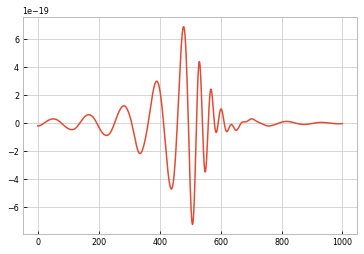

In [7]:
plt.plot(hp.data)

In [8]:
stimes = np.linspace(-0.15, 0.01, 1000)
hp, hx = generator.bilby(stimes, 65, 22, 1000).values()

In [9]:
%%timeit
hp, hx = generator.bilby(stimes, 65, 22, 1000).values()

1.19 s ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


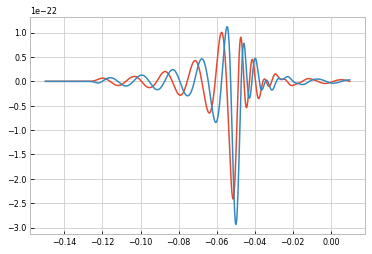

In [10]:
plt.plot(stimes, hp)
plt.plot(stimes, hx)

In [11]:
import bilby

11:43 bilby INFO    : Running bilby version: 0.5.8: (CLEAN) ace1c8d5 2019-10-01 10:12:09 +0100
11:43 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.
11:43 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.
11:43 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.


In [12]:
duration = 0.16
sampling_frequency = 4000
waveform = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    time_domain_source_model=generator.bilby,
    start_time=-0.15)

In [13]:
# inject the signal into three interferometers
ifos = bilby.gw.detector.InterferometerList(['L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=0)

/home/daniel/repositories/ligo/bilby/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise


In [25]:
injection_parameters = {"mass_1": 20, "mass_2": 20, "luminosity_distance": 400, "geocent_time": 0, "ra": 0, "dec": 0, "psi": 0}
ifos.inject_signal(waveform_generator=waveform,
                   parameters=injection_parameters);

TypeError: 'NoneType' object is not iterable

In [15]:
priors = bilby.gw.prior.BBHPriorDict()

11:44 bilby INFO    : No prior given, using default BBH priors in /home/daniel/repositories/ligo/bilby/bilby/gw/prior_files/binary_black_holes.prior.


In [16]:
priors['mass_1'] = bilby.core.prior.Uniform(10, 30, name="mass_1")
priors['mass_2'] = bilby.core.prior.Uniform(10, 30, name="mass_2")

In [21]:
outdir="test_heron-2"
label="pe-test"

priors['geocent_time'] = bilby.core.prior.Uniform(
    minimum=injection_parameters['geocent_time'] - 1,
    maximum=injection_parameters['geocent_time'] + 1,
    name='geocent_time', latex_label='$t_c$', unit='$s$')
for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra', 'theta_jn',
            'dec', 'geocent_time', 'phase']:
    if key in injection_parameters:
        priors[key] = injection_parameters[key]
    priors[key] = 0 #injection_parameters[key]
    
priors['luminosity_distance'] = 400

# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform)

11:45 bilby WARNING : The waveform_generator start_time is not equal to that of the provided interferometers. Overwriting the waveform_generator.


In [81]:
# Run sampler.  In this case we're going to use the `dynesty` sampler
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty', npoints=10,
    injection_parameters=injection_parameters, outdir=outdir, label=label)

15:43 bilby INFO    : Running for label 'pe-test', output will be saved to 'test_heron-2'
15:43 bilby INFO    : Using LAL version Branch: None;Tag: lalsuite-v6.62;Id: a75e6c243c5695e1abdcc4e5d91f623cf0db1d22;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
15:43 bilby INFO    : Search parameters:
15:43 bilby INFO    :   mass_1 = Uniform(minimum=10, maximum=30, name='mass_1', latex_label='$m_1$', unit=None, boundary=None)
15:43 bilby INFO    :   mass_2 = Uniform(minimum=10, maximum=30, name='mass_2', latex_label='$m_2$', unit=None, boundary=None)
15:43 bilby INFO    :   mass_ratio = Constraint(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None)
15:43 bilby INFO    :   a_1 = 0
15:43 bilby INFO    :   a_2 = 0
15:43 bilby INFO    :   tilt_1 = 0
15:43 bilby INFO    :   tilt_2 = 0
15:43 bilby INFO    :   phi_12 = 0
15:43 bilby INFO    :   phi_jl = 0
15:43 bilby INFO    :   luminosity_distance = 400
15:43 bilby INFO    :   dec = 0
15:43 bilby 

 26| logz ratio=-0.055 +/-    nan | dlogz:  0.008 >  0.100

15:45 bilby INFO    : Writing checkpoint file test_heron-2/pe-test_resume.pickle


 26| logz ratio=-0.055 +/-    nan | dlogz:  0.008 >  0.100

15:45 bilby INFO    : Sampling time: 0:01:15.507357
15:45 bilby INFO    : Summary of results:
nsamples: 36
log_noise_evidence: -678.107
log_evidence: -678.162 +/-    nan
log_bayes_factor: -0.055 +/-    nan



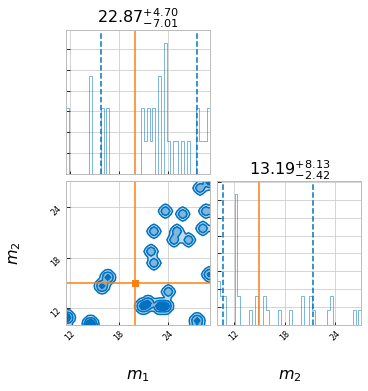

In [82]:
# Make a corner plot.
result.plot_corner()

In [ ]:
class HeronLikelihood(bilby.gw.likelihood.GravitationalWaveTransient)

    def log_likelihood_ratio(self):
        waveform_polarizations =\
            self.waveform_generator.frequency_domain_strain(self.parameters)

        if waveform_polarizations is None:
            return np.nan_to_num(-np.inf)

        d_inner_h = 0.
        optimal_snr_squared = 0.
        complex_matched_filter_snr = 0.
        if self.time_marginalization:
            if self.jitter_time:
                self.parameters['geocent_time'] += self.parameters['time_jitter']
            d_inner_h_tc_array = np.zeros(
                self.interferometers.frequency_array[0:-1].shape,
                dtype=np.complex128)

        for interferometer in self.interferometers:
            per_detector_snr = self.calculate_snrs(
                waveform_polarizations=waveform_polarizations,
                interferometer=interferometer)

            d_inner_h += per_detector_snr.d_inner_h
            optimal_snr_squared += np.real(per_detector_snr.optimal_snr_squared)
            complex_matched_filter_snr += per_detector_snr.complex_matched_filter_snr

            if self.time_marginalization:
                d_inner_h_tc_array += per_detector_snr.d_inner_h_squared_tc_array

        if self.time_marginalization:
            log_l = self.time_marginalized_likelihood(
                d_inner_h_tc_array=d_inner_h_tc_array,
                h_inner_h=optimal_snr_squared)
            if self.jitter_time:
                self.parameters['geocent_time'] -= self.parameters['time_jitter']

        elif self.distance_marginalization:
            log_l = self.distance_marginalized_likelihood(
                d_inner_h=d_inner_h, h_inner_h=optimal_snr_squared)

        elif self.phase_marginalization:
            log_l = self.phase_marginalized_likelihood(
                d_inner_h=d_inner_h, h_inner_h=optimal_snr_squared)

        else:
            log_l = np.real(d_inner_h) - optimal_snr_squared / 2

        return float(log_l.real)